# EDA 
EDA goals are:
- Perfom data quality checks, such as missing values, duplicates
- Understand data types
- Understand data distributions(descriptive metrics, outliers, data balance)

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Define the path to your Parquet file or directory
dataPath = "data.parquet"  # Adjust for single file or directory
# Read the Parquet data into a DataFrame
df = pd.read_parquet(dataPath)

In [4]:
df.head()

,col_0_numeric,col_1_numeric,col_2_numeric,col_3_numeric,col_4_numeric,col_5_numeric,col_6_numeric,col_7_numeric,col_8_numeric,col_9_numeric,...,col_318_numeric,col_319_numeric,col_320_numeric,col_321_numeric,col_322_numeric,col_323_numeric,col_324_numeric,col_325_numeric,label,col_327_other
0,270.983551,40.060154,NaN,NaN,0.476529,0.131972,NaN,NaN,NaN,NaN,...,NaN,21.428572,7.142857,0.0,NaN,NaN,258.870544,NaN,Continue,2024-04-28 02:04:00.944030
1,NaN,7.867676,NaN,NaN,17.629303,26.530045,NaN,NaN,NaN,NaN,...,64.812294,85.714287,78.571426,0.0,-2.163792,80.260124,-151.599518,53.983444,Continue,2024-04-28 02:12:55.364655
2,NaN,7.867676,NaN,NaN,17.629303,26.530045,NaN,NaN,25.218269,96.353047,...,64.812294,85.714287,78.571426,0.0,-2.163792,80.260124,-151.599518,53.983444,Continue,2024-04-28 02:12:55.364655
3,NaN,7.867676,NaN,NaN,17.629303,26.530045,NaN,NaN,828.416504,1989.064141,...,64.812294,85.714287,78.571426,0.0,-2.163792,80.260124,-151.599518,53.983444,Continue,2024-04-28 02:12:55.364655
4,NaN,7.867676,NaN,NaN,17.629303,26.530045,NaN,NaN,71.380898,300.839694,...,64.812294,85.714287,78.571426,0.0,-2.163792,80.260124,-151.599518,53.983444,Continue,2024-04-28 02:12:55.364655


In [5]:
df.shape

(11533904, 328)

In [18]:
df.label.value_counts()/df.shape[0]

label
Continue       0.98555
Interrupted    0.01445
Name: count, dtype: float64

In [3]:
df.duplicated().sum()

In [ ]:
df.dtypes.value_counts()

In [21]:
df_interrupted = df[df['label'] == 'Interrupted']

In [19]:
df_stats = df.describe()

In [20]:
missing_values_per_column = df.isnull().sum()/df.shape[0]


<Axes: >

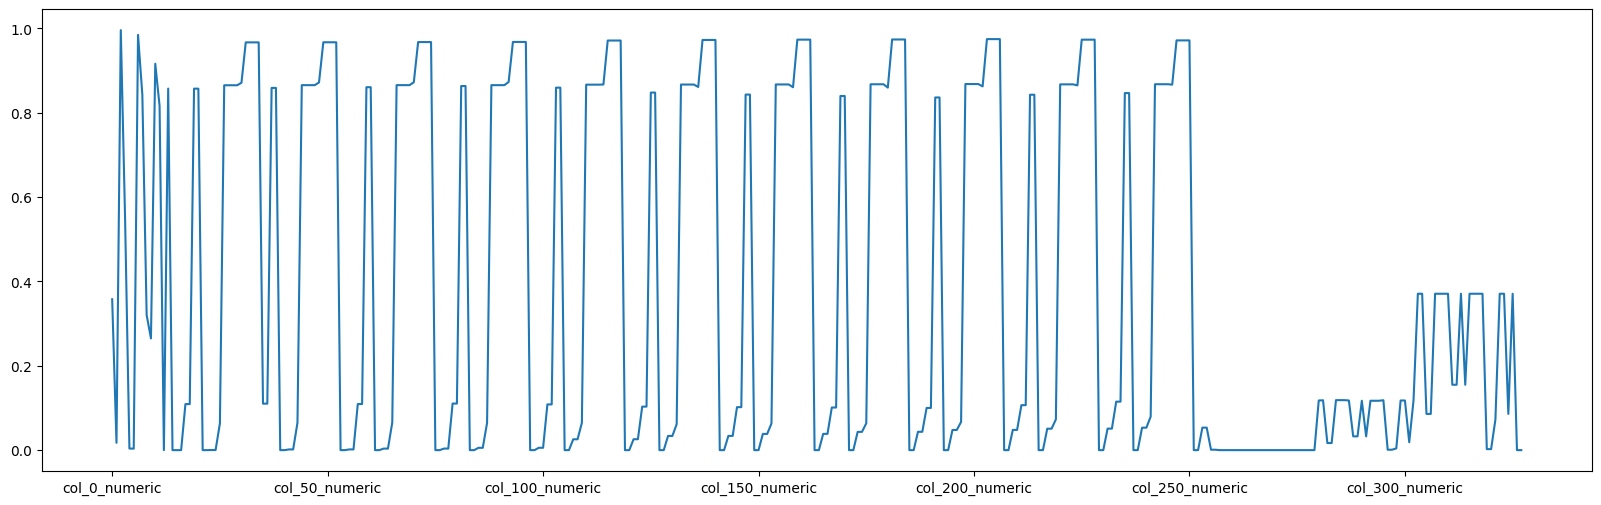

In [16]:
missing_values_per_column.plot(kind='line', figsize=(20, 6))

<Axes: >

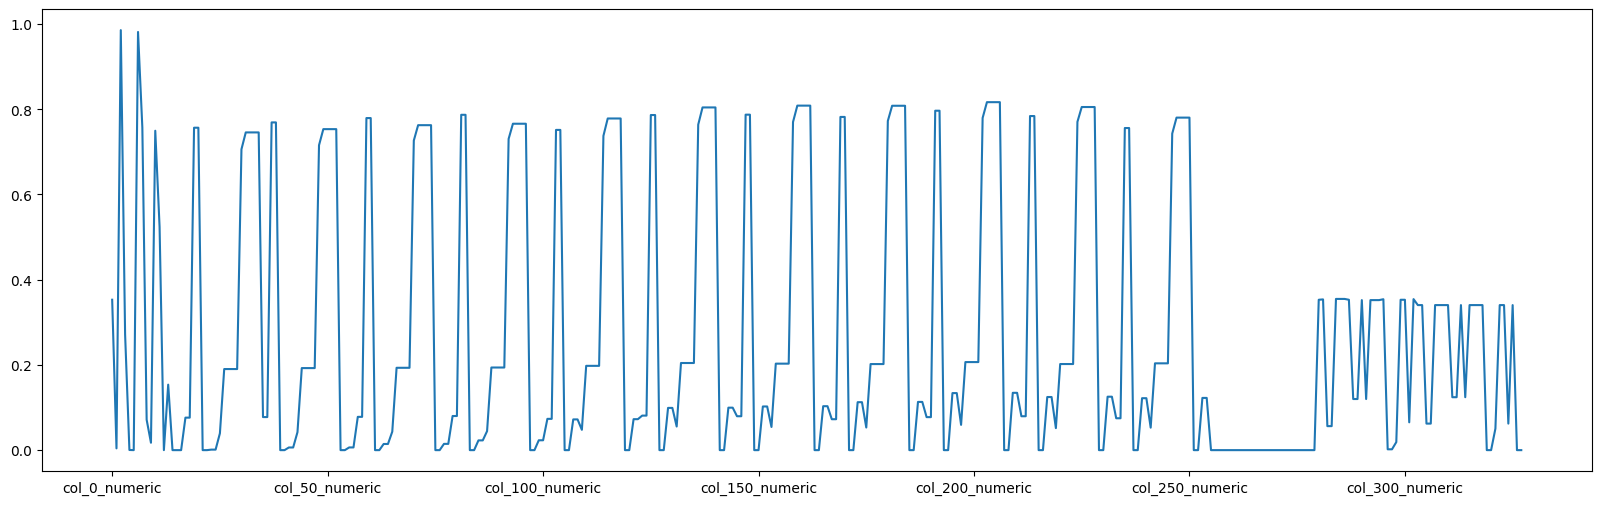

In [23]:
df_interrupted_missings = df_interrupted.isnull().sum()/df_interrupted.shape[0]
df_interrupted_missings.plot(kind='line', figsize=(20, 6))

<Axes: >

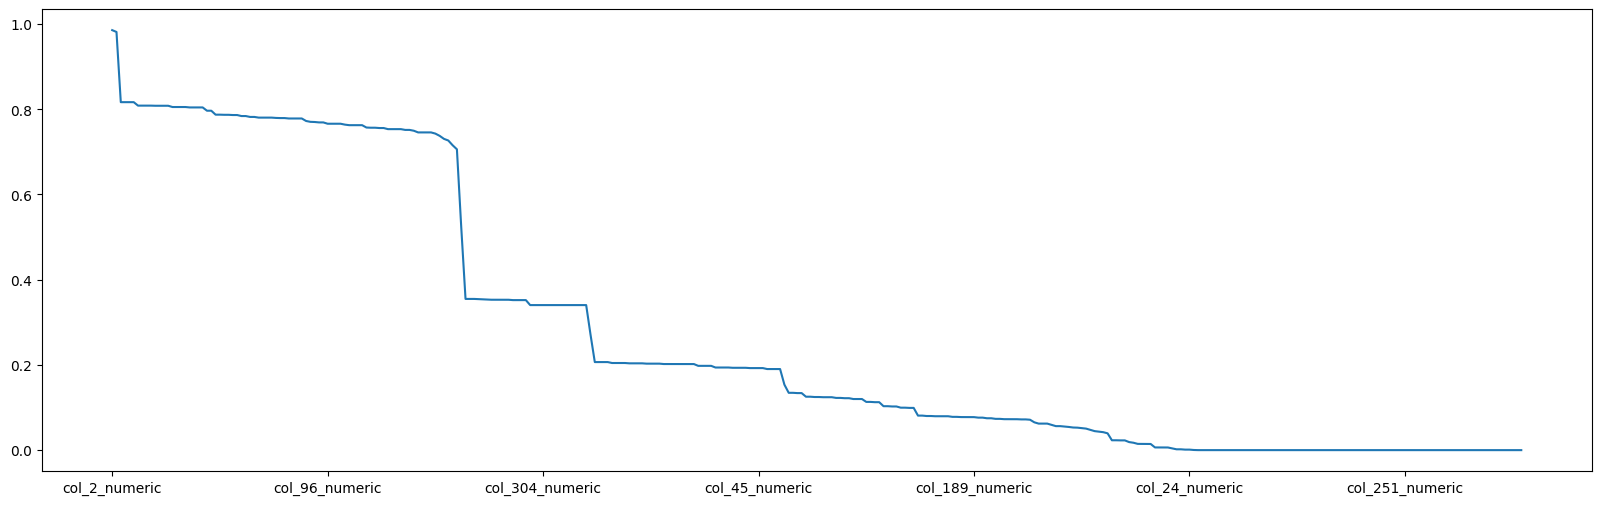

In [24]:
df_continue = df[df['label'] == 'Continue']
df_continue_missings = df_continue.isnull().sum()/df_continue.shape[0]
df_diff_missings = df_continue_missings - df_interrupted_missings


In [29]:
df_diff_missings.index

Index(['col_0_numeric', 'col_1_numeric', 'col_2_numeric', 'col_3_numeric',
       'col_4_numeric', 'col_5_numeric', 'col_6_numeric', 'col_7_numeric',
       'col_8_numeric', 'col_9_numeric',
       ...
       'col_318_numeric', 'col_319_numeric', 'col_320_numeric',
       'col_321_numeric', 'col_322_numeric', 'col_323_numeric',
       'col_324_numeric', 'col_325_numeric', 'label', 'col_327_other'],
      dtype='object', length=328)

(array([-50.,   0.,  50., 100., 150., 200., 250., 300., 350.]),
 [Text(-50.0, 0, 'col_99_numeric'),
  Text(0.0, 0, 'col_13_numeric'),
  Text(50.0, 0, 'col_33_numeric'),
  Text(100.0, 0, 'col_104_numeric'),
  Text(150.0, 0, 'col_309_numeric'),
  Text(200.0, 0, 'col_260_numeric'),
  Text(250.0, 0, 'col_149_numeric'),
  Text(300.0, 0, 'col_174_numeric'),
  Text(350.0, 0, '')])

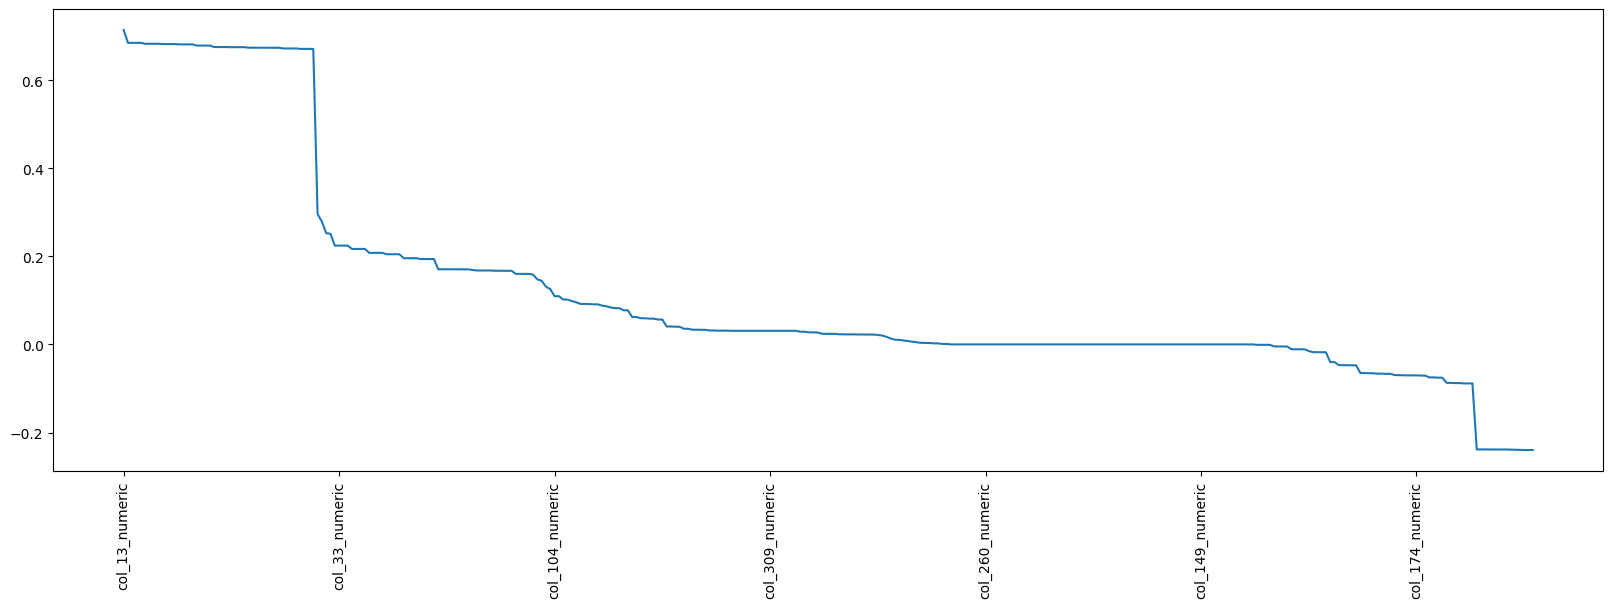

In [32]:

df_diff_missings.sort_values(ascending=False).plot(kind='line', figsize=(20, 6))
# ax.set_xticks(list(df_diff_missings.index))
# ax.set_xticklabels(df_diff_missings.index, rotation=90)
plt.xticks(rotation=90)


In [73]:
def plot_multiple_lines(data, x_col, y_cols, title='Multiple Line Plot', xlabel='X-axis', ylabel='Y-axis', rotation=45):
    """
    Plots multiple lines using Seaborn's lineplot function.

    Parameters:
    - data: DataFrame containing the data.
    - labels: Dictionary mapping y_cols to their respective labels.
    - x_col: Column name for the x-axis.
    - y_cols: List of column names for the y-axis.
    - title: Title of the plot (default 'Multiple Line Plot').
    - xlabel: Label for the x-axis (default 'X-axis').
    - ylabel: Label for the y-axis (default 'Y-axis').
    - rotation: Rotation angle for the x-axis labels (default 45 degrees).
    """
    plt.figure(figsize=(10, 6))

    for y_col in y_cols:
        sns.lineplot(data=data, x=x_col, y=y_col, label=y_col)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.semilogy()
    plt.xticks(rotation=rotation)
    plt.legend()
    plt.grid(True)
    plt.show()

In [77]:
df_stats_t = pd.DataFrame(df_stats).T.drop(['count','max'], axis=1).drop('col_327_other', axis=0).sort_values(['mean', '50%'], ascending=False)

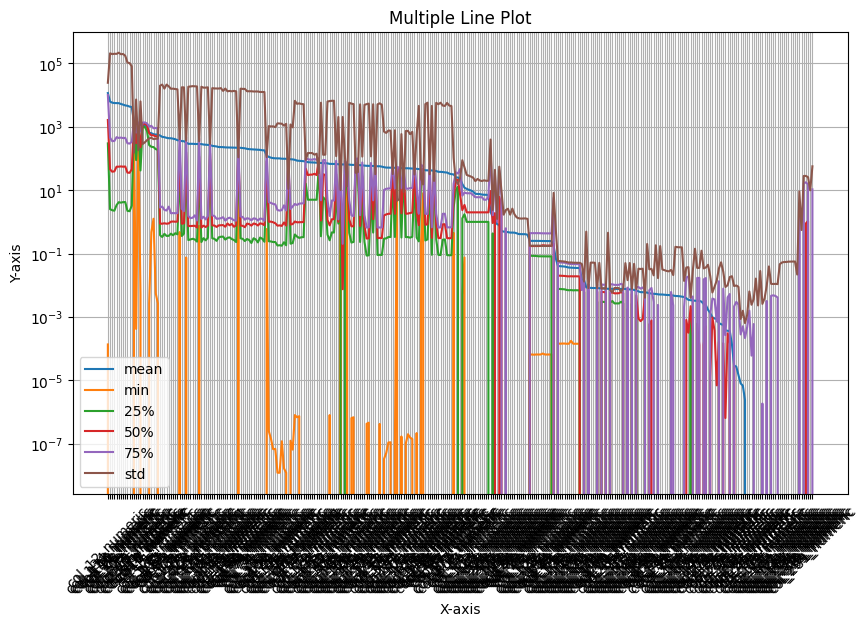

In [78]:

plot_multiple_lines(data=df_stats_t, x_col=list(df_stats_t.index), y_cols=list(df_stats_t.columns), title='Multiple Line Plot', xlabel='X-axis', ylabel='Y-axis', rotation=45)

In [79]:
df.dtypes

col_0_numeric             float32
col_1_numeric             float32
col_2_numeric             float32
col_3_numeric             float32
col_4_numeric             float32
                        ...      
col_323_numeric           float32
col_324_numeric           float32
col_325_numeric           float32
label                      object
col_327_other      datetime64[us]
Length: 328, dtype: object

In [4]:
df_numeric = df.select_dtypes(include=['number'])
correlation = df_numeric.corr()

# Create heatmap
plt.matshow(correlation)

# Add colorbar
plt.colorbar()

# Set labels for each cell (optional)
# for i in range(len(correlation.columns)):
#   for j in range(len(correlation.columns)):
#     plt.text(i, j, f"{correlation.iloc[i, j]:.2f}", ha='center', va='center')

# Set ticks and labels for axes
plt.xticks(range(len(correlation.columns)), correlation.columns, rotation=45)
plt.yticks(range(len(correlation.columns)), correlation.columns)

plt.show()